In [1]:
import os
from pathlib import Path

import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import numpy as np
import uproot
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea import dataset_tools

import time
import warnings

warnings.filterwarnings("ignore")

# local: single thread, single worker
from dask.distributed import LocalCluster, Client, progress
cluster = LocalCluster(n_workers=1, processes=False, threads_per_worker=1)
client = Client(cluster)

# for UChicago
# client = Client("tcp://dask-alheld-a76c9434-b.af-jupyter:8786")

print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

awkward: 2.6.2
dask-awkward: 2024.3.0
uproot: 5.3.2
hist: 2.7.2
coffea: 2024.3.0


### interactive coffea for debugging

In [2]:
fname = "/data/alheld/200gbps-atlas/mc23_13p6TeV.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.deriv.DAOD_PHYSLITE.e8514_s4162_r14622_p6026/DAOD_PHYSLITE.37223155._000001.pool.root.1"
treename = "CollectionTree"
# events = NanoEventsFactory.from_root({fname: treename}, schemaclass=PHYSLITESchema).events()

### distributed coffea

In [3]:
def materialize_branches(events):
    # track number of events
    num_events = ak.num(events, axis=0)

    # this will read around 10% of the file
    # materialize branches, just derive integers from them that will be aggregated to avoid memory issues
    _counter = 0
    _counter += ak.count_nonzero(events.Jets.EnergyPerSampling)
    _counter += ak.count_nonzero(events.Jets.SumPtTrkPt500)
    _counter += ak.count_nonzero(events.Jets.TrackWidthPt1000)
    _counter += ak.count_nonzero(events.Jets.NumTrkPt500)
    _counter += ak.count_nonzero(events.Jets.NumTrkPt1000)
    _counter += ak.count_nonzero(events.Jets.SumPtChargedPFOPt500)
    _counter += ak.count_nonzero(events.Jets.Timing)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_eta)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_eta)
    _counter += ak.count_nonzero(events.Jets.DetectorEta)
    _counter += ak.count_nonzero(events.Jets.eta)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_phi)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_phi)
    _counter += ak.count_nonzero(events.Jets.phi)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_m)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_pt)
    _counter += ak.count_nonzero(events.Jets.Width)
    _counter += ak.count_nonzero(events.Jets.EMFrac)
    _counter += ak.count_nonzero(events.Jets.pt)
    _counter += ak.count_nonzero(events.Jets.m)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_m)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_pt)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_QGTagger_TracksWidth)
    _counter += ak.count_nonzero(events.Jets.JVFCorr)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_QGTagger_TracksC1)
    _counter += ak.count_nonzero(events.Jets.PSFrac)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_QGTagger_NTracks)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_fJvt)
    _counter += ak.count_nonzero(events.Jets.PartonTruthLabelID)
    _counter += ak.count_nonzero(events.Jets.HadronConeExclExtendedTruthLabelID)
    _counter += ak.count_nonzero(events.Jets.ConeTruthLabelID)
    _counter += ak.count_nonzero(events.Jets.HadronConeExclTruthLabelID)

    return {"nevts": num_events, "_counter": _counter}

just run over a local ttbar file here as an example

In [4]:
fileset = {"ttbar": {"files": {fname: treename}}}
fileset

{'ttbar': {'files': {'/data/alheld/200gbps-atlas/mc23_13p6TeV.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.deriv.DAOD_PHYSLITE.e8514_s4162_r14622_p6026/DAOD_PHYSLITE.37223155._000001.pool.root.1': 'CollectionTree'}}}

In [5]:
%%time
# pre-process
samples, _ = dataset_tools.preprocess(fileset, step_size=1_000_000)

CPU times: user 1.25 s, sys: 48.7 ms, total: 1.29 s
Wall time: 1.28 s


In [6]:
def filter_name(name):
    return name in [
        "AnalysisJetsAuxDyn.EnergyPerSampling",
        "AnalysisJetsAuxDyn.SumPtTrkPt500",
        "AnalysisJetsAuxDyn.TrackWidthPt1000",
        "AnalysisJetsAuxDyn.NumTrkPt500",
        "AnalysisJetsAuxDyn.NumTrkPt1000",
        "AnalysisJetsAuxDyn.SumPtChargedPFOPt500",
        "AnalysisJetsAuxDyn.Timing",
        "AnalysisJetsAuxDyn.JetConstitScaleMomentum_eta",
        "AnalysisJetsAuxDyn.ActiveArea4vec_eta",
        "AnalysisJetsAuxDyn.DetectorEta",
        "AnalysisJetsAuxDyn.eta",
        "AnalysisJetsAuxDyn.JetConstitScaleMomentum_phi",
        "AnalysisJetsAuxDyn.ActiveArea4vec_phi",
        "AnalysisJetsAuxDyn.phi",
        "AnalysisJetsAuxDyn.JetConstitScaleMomentum_m",
        "AnalysisJetsAuxDyn.JetConstitScaleMomentum_pt",
        "AnalysisJetsAuxDyn.Width",
        "AnalysisJetsAuxDyn.EMFrac",
        "AnalysisJetsAuxDyn.pt",
        "AnalysisJetsAuxDyn.m",
        "AnalysisJetsAuxDyn.ActiveArea4vec_m",
        "AnalysisJetsAuxDyn.ActiveArea4vec_pt",
        "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksWidth",
        "AnalysisJetsAuxDyn.JVFCorr",
        "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksC1",
        "AnalysisJetsAuxDyn.PSFrac",
        "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_NTracks",
        "AnalysisJetsAuxDyn.DFCommonJets_fJvt",
        "AnalysisJetsAuxDyn.PartonTruthLabelID",
        "AnalysisJetsAuxDyn.HadronConeExclExtendedTruthLabelID",
        "AnalysisJetsAuxDyn.ConeTruthLabelID",
        "AnalysisJetsAuxDyn.HadronConeExclTruthLabelID",
        "AnalysisJetsAuxDyn.truthParticleLink",
        "AnalysisJetsAuxDyn.firstEgMotherTruthParticleLink",
        "AnalysisJetsAuxDyn.momentumBalanceSignificance",
        "AnalysisJetsAuxDyn.topoetcone20_CloseByCorr",
        "AnalysisJetsAuxDyn.scatteringCurvatureSignificance",
        "AnalysisJetsAuxDyn.neflowisol20_CloseByCorr",
        "AnalysisJetsAuxDyn.scatteringNeighbourSignificance",
        "AnalysisJetsAuxDyn.topoetcone20",
        "AnalysisJetsAuxDyn.topoetcone30",
        "AnalysisJetsAuxDyn.topoetcone40",
    ]

In [7]:
%%time
# create the task graph
# filter_name seems to not do anything here in terms of performance
tasks = dataset_tools.apply_to_fileset(materialize_branches,
                                       samples,
                                       uproot_options={"allow_read_errors_with_report": True, "filter_name": filter_name},
                                       schemaclass=PHYSLITESchema)

CPU times: user 3.1 s, sys: 72.8 ms, total: 3.18 s
Wall time: 3.15 s


execute task graph

In [8]:
%%time
# execute
t0 = time.perf_counter()
((out, report),) = dask.compute(tasks)  # feels strange that this is a tuple-of-tuple
t1 = time.perf_counter()

print(f"total time spent in uproot reading data: {ak.sum([v['duration'] for v in report.values()]):.2f} s")
print(f"wall time: {t1-t0:.2f}s")

total time spent in uproot reading data: 13.00 s
wall time: 13.74s
CPU times: user 7.73 s, sys: 6.28 s, total: 14 s
Wall time: 13.7 s


In [9]:
out

{'ttbar': {'nevts': 30000, '_counter': 20461220}}

In [10]:
event_rate = out["ttbar"]["nevts"] / (t1-t0)
print(f"event rate: {event_rate / 1_000:.2f} kHz")

event rate: 2.18 kHz


In [11]:
# need uproot>=5.3.2 to get more useful performance stats

print(f"read {sum(report['ttbar']['performance_counters']['num_requested_bytes']) / 1_000**2:.2f} MB")

read 84.67 MB


In [12]:
# sanity check that the right colums are being touched
dak.report_necessary_columns(tasks)

{'from-uproot-ca17f7245124d5cfc0a5420e734b90c3': frozenset({'AnalysisJetsAuxDyn.ActiveArea4vec_eta',
            'AnalysisJetsAuxDyn.ActiveArea4vec_m',
            'AnalysisJetsAuxDyn.ActiveArea4vec_phi',
            'AnalysisJetsAuxDyn.ActiveArea4vec_pt',
            'AnalysisJetsAuxDyn.ConeTruthLabelID',
            'AnalysisJetsAuxDyn.DFCommonJets_QGTagger_NTracks',
            'AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksC1',
            'AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksWidth',
            'AnalysisJetsAuxDyn.DFCommonJets_fJvt',
            'AnalysisJetsAuxDyn.DetectorEta',
            'AnalysisJetsAuxDyn.EMFrac',
            'AnalysisJetsAuxDyn.EnergyPerSampling',
            'AnalysisJetsAuxDyn.HadronConeExclExtendedTruthLabelID',
            'AnalysisJetsAuxDyn.HadronConeExclTruthLabelID',
            'AnalysisJetsAuxDyn.JVFCorr',
            'AnalysisJetsAuxDyn.JetConstitScaleMomentum_eta',
            'AnalysisJetsAuxDyn.JetConstitScaleMomentum_m',
          

### non-coffea / non-Dask version to compare

In [13]:
BRANCH_LIST = [
    "AnalysisJetsAuxDyn.EnergyPerSampling",
    "AnalysisJetsAuxDyn.SumPtTrkPt500",
    "AnalysisJetsAuxDyn.TrackWidthPt1000",
    "AnalysisJetsAuxDyn.NumTrkPt500",
    "AnalysisJetsAuxDyn.NumTrkPt1000",
    "AnalysisJetsAuxDyn.SumPtChargedPFOPt500",
    "AnalysisJetsAuxDyn.Timing",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_eta",
    "AnalysisJetsAuxDyn.ActiveArea4vec_eta",
    "AnalysisJetsAuxDyn.DetectorEta",
    "AnalysisJetsAuxDyn.eta",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_phi",
    "AnalysisJetsAuxDyn.ActiveArea4vec_phi",
    "AnalysisJetsAuxDyn.phi",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_m",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_pt",
    "AnalysisJetsAuxDyn.Width",
    "AnalysisJetsAuxDyn.EMFrac",
    "AnalysisJetsAuxDyn.pt",
    "AnalysisJetsAuxDyn.m",
    "AnalysisJetsAuxDyn.ActiveArea4vec_m",
    "AnalysisJetsAuxDyn.ActiveArea4vec_pt",
    "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksWidth",
    "AnalysisJetsAuxDyn.JVFCorr",
    "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksC1",
    "AnalysisJetsAuxDyn.PSFrac",
    "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_NTracks",
    "AnalysisJetsAuxDyn.DFCommonJets_fJvt",
    "AnalysisJetsAuxDyn.PartonTruthLabelID",
    "AnalysisJetsAuxDyn.HadronConeExclExtendedTruthLabelID",
    "AnalysisJetsAuxDyn.ConeTruthLabelID",
    "AnalysisJetsAuxDyn.HadronConeExclTruthLabelID"
]

def filter_name(name):
    return name in BRANCH_LIST

file_size = os.path.getsize(fname) / 1000**2  # all sizes in MB

time_per_fraction_read = {}
for i in range(len(BRANCH_LIST)//4+1):
    with uproot.open({fname: treename}, filter_name=filter_name) as f:  # re-open every time for accurate tracking of data read
        branches = BRANCH_LIST[0:i*4+1]
        print(f"reading {len(branches)} branch(es)")
        initial_metadata_in_MB = f.file.source.num_requested_bytes/1000**2
        t0 = time.perf_counter()
        f.arrays(branches)
        t1 = time.perf_counter()
        new_size_in_MB = f.file.source.num_requested_bytes/1000**2
        fraction_read = (new_size_in_MB - initial_metadata_in_MB) / file_size
        time_per_fraction_read[fraction_read] = t1 - t0
        print(f"read {new_size_in_MB - initial_metadata_in_MB:.2f} MB in {t1 - t0:.2f} s")

with uproot.open({fname: treename}) as f:
    nevts = f.num_entries

reading 1 branch(es)
read 8.67 MB in 0.83 s
reading 5 branch(es)
read 26.30 MB in 4.19 s
reading 9 branch(es)
read 31.79 MB in 5.96 s
reading 13 branch(es)
read 36.85 MB in 6.02 s
reading 17 branch(es)
read 41.77 MB in 5.97 s
reading 21 branch(es)
read 46.57 MB in 6.24 s
reading 25 branch(es)
read 50.69 MB in 6.03 s
reading 29 branch(es)
read 52.71 MB in 6.44 s
reading 32 branch(es)
read 53.44 MB in 6.57 s


In [14]:
for k, v in time_per_fraction_read.items():
    print(f"fraction read: {k:.2%} in {v:.2f} s")

fraction read: 1.56% in 0.83 s
fraction read: 4.74% in 4.19 s
fraction read: 5.73% in 5.96 s
fraction read: 6.64% in 6.02 s
fraction read: 7.53% in 5.97 s
fraction read: 8.39% in 6.24 s
fraction read: 9.13% in 6.03 s
fraction read: 9.50% in 6.44 s
fraction read: 9.63% in 6.57 s


(0.0, 37.82096972465515)

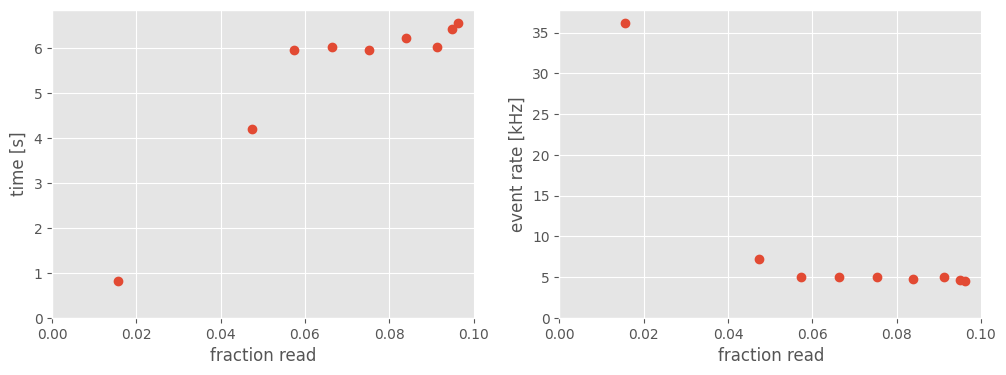

In [15]:
event_rate_in_kHz = nevts / np.fromiter(time_per_fraction_read.values(), np.float32) / 1_000

fig, (ax0, ax1) = plt.subplots(figsize=(12,4), ncols=2)

ax0.plot(time_per_fraction_read.keys(), time_per_fraction_read.values(), "o")
ax0.set_xlabel("fraction read")
ax0.set_ylabel("time [s]")
ax0.set_xlim([0, ax0.get_xlim()[1]])
ax0.set_ylim([0, ax0.get_ylim()[1]])

ax1.plot(time_per_fraction_read.keys(), event_rate_in_kHz, "o")
ax1.set_xlabel("fraction read")
ax1.set_ylabel("event rate [kHz]")
ax1.set_xlim([0, ax1.get_xlim()[1]])
ax1.set_ylim([0, ax1.get_ylim()[1]])

In [16]:
# pure "metadata" (?) part, would be read on every open call
with uproot.open({fname: treename}) as f:
    print(f"{f.file.source.num_requested_bytes/1000**2:.2f} MB")

0.83 MB


(0.0, 85.87495975494384)

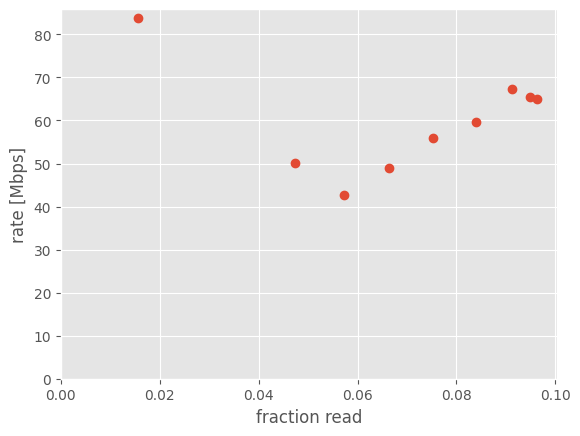

In [17]:
# fraction read * file size (in MB) * 8 (to Mb) / time (in s)
io_in_Mbps = np.fromiter(time_per_fraction_read.keys(), np.float32) * file_size * 8 / np.fromiter(time_per_fraction_read.values(), np.float32)

fig, ax = plt.subplots()

ax.plot(time_per_fraction_read.keys(), io_in_Mbps, "o")
ax.set_xlabel("fraction read")
ax.set_ylabel("rate [Mbps]")
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])